In [1]:
from light_curves import LightCurve
from exposures import Calexp
from task import Run
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

In [ ]:
radius = 0.2 #[0.1,0.2,0.3, 0.5]
density = 50/0.05#]np.array([10,50, 100, 500])/0.05
n_max_calexps = 1000
bands = "ugrizy"
problems = []
delta_mag = np.array([10,7,4,2,1,0])


process = Run(ra=57.59451632893858, dec=-32.481152201226145, 
              density = density, scale = radius, bands = bands, 
              name = f"run_{density:.0f}dens_{int(radius*10):02d}rad_{bands}_{n_max_calexps}calexps", 
              calexp_method="overlap", measure_method ="ForcedMeas")
print(process)
process.inject_task()
schema = process.measure_task()

process.collect_calexp()
process.data_calexp.to_csv(process.main_path+'/data_calexp.csv', index=False)
for event_id, m in enumerate(tqdm(np.linspace(17,22,process.n_lc), desc="Loading events:")):
    lc_ra, lc_dec = process.generate_location()
    params = {"t_0": random.uniform(60300,61500),
   "t_E": random.uniform(20, 200), 
   "u_0": random.uniform(0.1,1)}
    for band, dm in zip(process.bands, delta_mag):
        params["m_base"]=m+dm
        process.add_lc(lc_ra, lc_dec, params, event_id=event_id, band=band)
process.data_events.to_csv(process.main_path+'/data_events.csv', index=False) 
# process.sky_map()
process.log_task("Add and simulate light curves")



for idx, data in process.data_calexp.iterrows():
    if idx >= n_max_calexps:
        break
    print(f" ------ CALEXP {idx+1}/{n_max_calexps} ------")
    data_id = data[['detector', 'visit']].to_dict()
    calexp = Calexp(data_id)
    if calexp.overlaps(process.region):
        band = data["band"]; print("Band: ", band)
        # ax = calexp.plot() 
        # for lc in process.inj_lc:
        #     calexp.add_point(ax, lc.ra, lc.dec, r=40)
        # plt.show()
        process.data_calexp.loc[(process.data_calexp["detector"] == data_id["detector"]) & (process.data_calexp["visit"] == data_id["visit"]),"overlap"] = True
        injection_catalog = process.create_injection_table(calexp, band)
        injection_catalog_checked = process.check_injection_catalog(calexp, catalog = injection_catalog)
        
        # print(f"{injection_catalog_checked=}")
        if injection_catalog_checked:
            print(f"{band=}")
            injected_exposure, injected_catalog = process.inject_calexp(calexp, injection_catalog_checked, save_fit=f"calexp_{idx}_{band}.fit")
            if injected_catalog != None:
                inj_calexp = Calexp(injected_exposure)
                # ax = inj_calexp.plot() 
                #     if lcc["injection_flag"] != 0:
                #         color = "cyan"
                #     else:
                #         color = "red"
                #     inj_calexp.add_point(ax, lcc["ra"], lcc["dec"], r=40, c=color)
                # plt.show()
                injected_catalog_checked = process.check_injection_catalog(calexp, injected_catalog, before_injection=False)
                if len(injected_catalog_checked)>0:
                    table, sources = process.measurement(schema, inj_calexp, injected_catalog)
                    for _, lc_inj in table.iterrows():
                        filtered_idx = process.data_events[
                            (process.data_events["ra"] == lc_inj["ra"]) &
                            (process.data_events["dec"] == lc_inj["dec"]) &
                            (process.data_events["band"] == band)].index
                        id_lc_inj = filtered_idx[0] if not filtered_idx.empty else None
                        lc = process.inj_lc[id_lc_inj]
                        flux, flux_err, mag, mag_err = table.loc[(table["ra"] == lc.ra) & (table["dec"] == lc.dec), ["flux", "flux_err", "mag", "mag_err"]].values[0]
                        lc.add_data(data_id, [flux, flux_err, mag, mag_err])
                        # print("-"*50) ["mjd", "detector", "visit", "flux", "flux_err", "mag", "mag_err"]
                        # print(f"ra = {lc.ra}, dec = {lc.dec}, id = {id_lc_inj}, band = {lc.band}")
                        # print("Measured ", mag, mag_err)
                        # print("Injected", lc.data["mag_sim"][idx])
                        # is_within_range = (mag - mag_err <= lc.data["mag_sim"][idx] <= mag + mag_err)
                        # print("Injected within range:", is_within_range)
                        # print("Injected inj_catalog ", lc_inj["mag"])
                        try:
                            if abs(mag-lc.data["mag_inj"][idx])>1:
                                problems.append([idx, id_lc_inj, lc.ra, lc.dec])
                                # problems.append((idx, calexp, process.inj_lc[id_lc_inj], lc.ra , lc.dec, sources, injected_catalog, injected_catalog_checked, mag, mag_err, lc.data["mag_inj"][idx], injected_exposure))
                        except Exception as e:
                            print(f"flag: {e}")

        else:
            print("Injection catalog is empty")
        print(f"{len(problems)}")
    else:
        print("Not intersection between calexp and region.")
            
process.data_calexp.to_csv(process.main_path+'/data_calexp.csv', index=False)
process.data_events.to_csv(process.main_path+'/data_events.csv', index=False)  
process.save_lc()
process.save_time_log()
process.time_analysis()
print("Injected points per light curve", [lc.data["mag"].count() for lc in process.inj_lc] )
process.sky_map(calexps=n_max_calexps)
for band in process.bands:
    process.sky_map(calexps=n_max_calexps, band=band)

Log saved in: runs/run_1000dens_02rad_ugrizy_1000calexps/run_1000dens_02rad_ugrizy_1000calexps_log.txt
--------------------------------------------------------------------------------
Run Name: run_1000dens_02rad_ugrizy_1000calexps
Center: RA=57.59451632893858, Dec=-32.481152201226145
Band: ugrizy
Calexp Method: overlap
Measure Method: ForcedMeas
Density: 1000.0 sources/deg²
Area: 0.126 deg²
Scale: 0.200 deg
Number of LightCurves to inject: 126
Main Path: runs/run_1000dens_02rad_ugrizy_1000calexps
--------------------------------------------------------------------------------
(ra,dec) = (57.59451632893858, -32.481152201226145) 
Circle of radius ~0.200 deg.
Found 3304 calexps.


Processing MJD values:   0%|          | 0/3304 [00:00<?, ?it/s]

Loading events::   0%|          | 0/126 [00:00<?, ?it/s]

 ------ CALEXP 1/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 2/1000 ------
Band:  z
Light curves NOT contained:  78
Light curves near edge:  16
band='z'


0
 ------ CALEXP 3/1000 ------
Band:  y
Light curves NOT contained:  54
Light curves near edge:  6
band='y'


0
 ------ CALEXP 4/1000 ------
Band:  y
Light curves NOT contained:  112
Light curves near edge:  11
band='y'


0
 ------ CALEXP 5/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  10
Injection catalog is empty
0
 ------ CALEXP 6/1000 ------
Band:  z
Light curves NOT contained:  126
Light curves near edge:  4
Injection catalog is empty
0
 ------ CALEXP 7/1000 ------
Band:  y
Light curves NOT contained:  125
Light curves near edge:  5
band='y'


0
 ------ CALEXP 8/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 9/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  7
Injection catalog is empty
0
 ------ CALEXP 10/1000 ------
Band:  u
Light curves NOT contained:  104
Light curves near edge:  12
band='u'


9
 ------ CALEXP 11/1000 ------
Band:  r
Light curves NOT contained:  125
Light curves near edge:  6
band='r'


9
 ------ CALEXP 12/1000 ------
Band:  z
Light curves NOT contained:  125
Light curves near edge:  5
Injection catalog is empty
9
 ------ CALEXP 13/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 14/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  10
Injection catalog is empty
9
 ------ CALEXP 15/1000 ------
Band:  r
Light curves NOT contained:  117
Light curves near edge:  9
band='r'


9
 ------ CALEXP 16/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  4
Injection catalog is empty
9
 ------ CALEXP 17/1000 ------
Band:  g
Light curves NOT contained:  112
Light curves near edge:  12
band='g'


11
 ------ CALEXP 18/1000 ------
Band:  r
Light curves NOT contained:  122
Light curves near edge:  8
band='r'


11
 ------ CALEXP 19/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 20/1000 ------
Band:  y
Light curves NOT contained:  126
Light curves near edge:  10
Injection catalog is empty
11
 ------ CALEXP 21/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  4
Injection catalog is empty
11
 ------ CALEXP 22/1000 ------
Band:  r
Light curves NOT contained:  121
Light curves near edge:  9
band='r'


11
 ------ CALEXP 23/1000 ------
Band:  i
Light curves NOT contained:  80
Light curves near edge:  12
band='i'


11
 ------ CALEXP 24/1000 ------
Band:  z
Light curves NOT contained:  123
Light curves near edge:  7
band='z'


11
 ------ CALEXP 25/1000 ------
Band:  g
Light curves NOT contained:  126
Light curves near edge:  4
Injection catalog is empty
11
 ------ CALEXP 26/1000 ------
Band:  i
Light curves NOT contained:  125
Light curves near edge:  6
band='i'


11
 ------ CALEXP 27/1000 ------
Band:  z
Light curves NOT contained:  112
Light curves near edge:  11
band='z'


11
 ------ CALEXP 28/1000 ------
Band:  y
Light curves NOT contained:  109
Light curves near edge:  8
band='y'


11
 ------ CALEXP 29/1000 ------
Band:  z
Light curves NOT contained:  126
Light curves near edge:  10
Injection catalog is empty
11
 ------ CALEXP 30/1000 ------
Band:  r
Light curves NOT contained:  121
Light curves near edge:  9
band='r'


11
 ------ CALEXP 31/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 32/1000 ------
Band:  u
Light curves NOT contained:  106
Light curves near edge:  9
band='u'


19
 ------ CALEXP 33/1000 ------
Band:  u
Light curves NOT contained:  91
Light curves near edge:  11
band='u'


37
 ------ CALEXP 34/1000 ------
Band:  i
Light curves NOT contained:  62
Light curves near edge:  15
band='i'


38
 ------ CALEXP 35/1000 ------
Band:  r
Light curves NOT contained:  58
Light curves near edge:  17
band='r'


39
 ------ CALEXP 36/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 37/1000 ------
Band:  i
Light curves NOT contained:  115
Light curves near edge:  11
band='i'


39
 ------ CALEXP 38/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  10
Injection catalog is empty
39
 ------ CALEXP 39/1000 ------
Band:  r
Light curves NOT contained:  90
Light curves near edge:  11
band='r'


41
 ------ CALEXP 40/1000 ------
Band:  y
Light curves NOT contained:  53
Light curves near edge:  11
band='y'


41
 ------ CALEXP 41/1000 ------
Band:  r
Light curves NOT contained:  53
Light curves near edge:  9
band='r'


46
 ------ CALEXP 42/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 43/1000 ------
Band:  i
Light curves NOT contained:  79
Light curves near edge:  13
band='i'


48
 ------ CALEXP 44/1000 ------
Band:  z
Light curves NOT contained:  122
Light curves near edge:  8
band='z'


48
 ------ CALEXP 45/1000 ------
Band:  z
Light curves NOT contained:  123
Light curves near edge:  15
band='z'


48
 ------ CALEXP 46/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 47/1000 ------
Band:  i
Light curves NOT contained:  117
Light curves near edge:  11
band='i'


48
 ------ CALEXP 48/1000 ------
Band:  u
Light curves NOT contained:  123
Light curves near edge:  8
band='u'


49
 ------ CALEXP 49/1000 ------
Band:  y
Light curves NOT contained:  106
Light curves near edge:  11
band='y'


49
 ------ CALEXP 50/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 51/1000 ------
Band:  i
Light curves NOT contained:  101
Light curves near edge:  12
band='i'


49
 ------ CALEXP 52/1000 ------
Band:  i
Light curves NOT contained:  94
Light curves near edge:  13
band='i'


49
 ------ CALEXP 53/1000 ------
Band:  r
Light curves NOT contained:  105
Light curves near edge:  15
band='r'


50
 ------ CALEXP 54/1000 ------
Band:  i
Light curves NOT contained:  124
Light curves near edge:  6
Injection catalog is empty
50
 ------ CALEXP 55/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  10
Injection catalog is empty
50
 ------ CALEXP 56/1000 ------
Band:  r
Light curves NOT contained:  101
Light curves near edge:  15
band='r'


53
 ------ CALEXP 57/1000 ------
Band:  y
Light curves NOT contained:  121
Light curves near edge:  12
band='y'


53
 ------ CALEXP 58/1000 ------
Band:  i
Light curves NOT contained:  102
Light curves near edge:  12
band='i'


53
 ------ CALEXP 59/1000 ------
Band:  r
Light curves NOT contained:  111
Light curves near edge:  10
band='r'


53
 ------ CALEXP 60/1000 ------
Band:  r
Light curves NOT contained:  122
Light curves near edge:  9
band='r'


53
 ------ CALEXP 61/1000 ------
Band:  y
Light curves NOT contained:  104
Light curves near edge:  14
band='y'


53
 ------ CALEXP 62/1000 ------
Band:  r
Light curves NOT contained:  112
Light curves near edge:  5
band='r'


55
 ------ CALEXP 63/1000 ------
Band:  r
Light curves NOT contained:  124
Light curves near edge:  9
band='r'


55
 ------ CALEXP 64/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 65/1000 ------
Band:  r
Light curves NOT contained:  96
Light curves near edge:  10
band='r'


56
 ------ CALEXP 66/1000 ------
Band:  z
Light curves NOT contained:  87
Light curves near edge:  19
band='z'


56
 ------ CALEXP 67/1000 ------
Band:  y
Light curves NOT contained:  109
Light curves near edge:  5
band='y'


56
 ------ CALEXP 68/1000 ------
Band:  y
Light curves NOT contained:  126
Light curves near edge:  7
Injection catalog is empty
56
 ------ CALEXP 69/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 70/1000 ------
Band:  i
Light curves NOT contained:  109
Light curves near edge:  6
band='i'


56
 ------ CALEXP 71/1000 ------
Band:  r
Light curves NOT contained:  116
Light curves near edge:  14
band='r'


57
 ------ CALEXP 72/1000 ------
Band:  u
Light curves NOT contained:  125
Light curves near edge:  6
band='u'


58
 ------ CALEXP 73/1000 ------
Band:  y
Light curves NOT contained:  48
Light curves near edge:  13
band='y'


58
 ------ CALEXP 74/1000 ------
Band:  r
Light curves NOT contained:  123
Light curves near edge:  5
band='r'


58
 ------ CALEXP 75/1000 ------
Band:  i
Light curves NOT contained:  77
Light curves near edge:  11
band='i'


58
 ------ CALEXP 76/1000 ------
Band:  r
Light curves NOT contained:  95
Light curves near edge:  8
band='r'


58
 ------ CALEXP 77/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 78/1000 ------
Band:  z
Light curves NOT contained:  95
Light curves near edge:  10
band='z'


58
 ------ CALEXP 79/1000 ------
Band:  g
Light curves NOT contained:  126
Light curves near edge:  13
Injection catalog is empty
58
 ------ CALEXP 80/1000 ------
Band:  r
Light curves NOT contained:  118
Light curves near edge:  11
band='r'


60
 ------ CALEXP 81/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 82/1000 ------
Band:  r
Light curves NOT contained:  103
Light curves near edge:  17
band='r'


63
 ------ CALEXP 83/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  7
Injection catalog is empty
63
 ------ CALEXP 84/1000 ------
Band:  g
Light curves NOT contained:  68
Light curves near edge:  8
band='g'


73
 ------ CALEXP 85/1000 ------
Band:  r
Light curves NOT contained:  125
Light curves near edge:  10
Injection catalog is empty
73
 ------ CALEXP 86/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  6
Injection catalog is empty
73
 ------ CALEXP 87/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 88/1000 ------
Band:  i
Light curves NOT contained:  122
Light curves near edge:  7
band='i'


73
 ------ CALEXP 89/1000 ------
Band:  i
Light curves NOT contained:  78
Light curves near edge:  11
band='i'


73
 ------ CALEXP 90/1000 ------
Band:  z
Light curves NOT contained:  117
Light curves near edge:  14
band='z'


73
 ------ CALEXP 91/1000 ------
Band:  y
Light curves NOT contained:  125
Light curves near edge:  6
band='y'


73
 ------ CALEXP 92/1000 ------
Band:  y
Light curves NOT contained:  125
Light curves near edge:  6
Injection catalog is empty
73
 ------ CALEXP 93/1000 ------
Band:  r
Light curves NOT contained:  50
Light curves near edge:  12
band='r'


80
 ------ CALEXP 94/1000 ------
Band:  y
Light curves NOT contained:  114
Light curves near edge:  11
band='y'


80
 ------ CALEXP 95/1000 ------
Band:  i
Light curves NOT contained:  115
Light curves near edge:  11
band='i'


80
 ------ CALEXP 96/1000 ------
Band:  r
Light curves NOT contained:  108
Light curves near edge:  11
band='r'


82
 ------ CALEXP 97/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  2
Injection catalog is empty
82
 ------ CALEXP 98/1000 ------
Band:  r
Light curves NOT contained:  116
Light curves near edge:  16
band='r'


84
 ------ CALEXP 99/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 100/1000 ------
Band:  r
Light curves NOT contained:  66
Light curves near edge:  11
band='r'


87
 ------ CALEXP 101/1000 ------
Band:  y
Light curves NOT contained:  110
Light curves near edge:  3
band='y'


87
 ------ CALEXP 102/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  9
Injection catalog is empty
87
 ------ CALEXP 103/1000 ------
Band:  i
Light curves NOT contained:  123
Light curves near edge:  7
band='i'


87
 ------ CALEXP 104/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 105/1000 ------
Band:  r
Light curves NOT contained:  122
Light curves near edge:  8
band='r'


87
 ------ CALEXP 106/1000 ------
Band:  y
Light curves NOT contained:  122
Light curves near edge:  11
band='y'


87
 ------ CALEXP 107/1000 ------
Band:  i
Light curves NOT contained:  96
Light curves near edge:  15
band='i'


87
 ------ CALEXP 108/1000 ------
Band:  i
Light curves NOT contained:  124
Light curves near edge:  8
band='i'


87
 ------ CALEXP 109/1000 ------
Band:  r
Light curves NOT contained:  118
Light curves near edge:  8
band='r'


88
 ------ CALEXP 110/1000 ------
Band:  i
Light curves NOT contained:  116
Light curves near edge:  12
band='i'


88
 ------ CALEXP 111/1000 ------
Band:  r
Light curves NOT contained:  72
Light curves near edge:  9
band='r'


90
 ------ CALEXP 112/1000 ------
Band:  r
Light curves NOT contained:  55
Light curves near edge:  16
band='r'


93
 ------ CALEXP 113/1000 ------
Band:  r
Light curves NOT contained:  114
Light curves near edge:  11
band='r'


94
 ------ CALEXP 114/1000 ------
Band:  r
Light curves NOT contained:  123
Light curves near edge:  11
band='r'


94
 ------ CALEXP 115/1000 ------
Band:  y
Light curves NOT contained:  115
Light curves near edge:  7
band='y'


94
 ------ CALEXP 116/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 117/1000 ------
Band:  r
Light curves NOT contained:  123
Light curves near edge:  5
band='r'


94
 ------ CALEXP 118/1000 ------
Band:  r
Light curves NOT contained:  110
Light curves near edge:  7
band='r'


96
 ------ CALEXP 119/1000 ------
Band:  i
Light curves NOT contained:  114
Light curves near edge:  13
band='i'


96
 ------ CALEXP 120/1000 ------
Band:  z
Light curves NOT contained:  89
Light curves near edge:  11
band='z'


96
 ------ CALEXP 121/1000 ------
Band:  y
Light curves NOT contained:  95
Light curves near edge:  10
band='y'


96
 ------ CALEXP 122/1000 ------
Band:  i
Light curves NOT contained:  95
Light curves near edge:  8
band='i'


96
 ------ CALEXP 123/1000 ------
Band:  r
Light curves NOT contained:  125
Light curves near edge:  10
Injection catalog is empty
96
 ------ CALEXP 124/1000 ------
Band:  u
Light curves NOT contained:  124
Light curves near edge:  11
band='u'


97
 ------ CALEXP 125/1000 ------
Band:  r
Light curves NOT contained:  88
Light curves near edge:  13
band='r'


101
 ------ CALEXP 126/1000 ------
Band:  y
Light curves NOT contained:  108
Light curves near edge:  9
band='y'


101
 ------ CALEXP 127/1000 ------
Band:  g
Light curves NOT contained:  107
Light curves near edge:  13
band='g'


105
 ------ CALEXP 128/1000 ------
Band:  r
Light curves NOT contained:  123
Light curves near edge:  10
band='r'


106
 ------ CALEXP 129/1000 ------
Band:  i
Light curves NOT contained:  103
Light curves near edge:  5
band='i'


106
 ------ CALEXP 130/1000 ------
Band:  i
Light curves NOT contained:  104
Light curves near edge:  11
band='i'


106
 ------ CALEXP 131/1000 ------
Band:  i
Light curves NOT contained:  124
Light curves near edge:  10
Injection catalog is empty
106
 ------ CALEXP 132/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 133/1000 ------
Band:  z
Light curves NOT contained:  126
Light curves near edge:  4
Injection catalog is empty
106
 ------ CALEXP 134/1000 ------
Band:  g
Light curves NOT contained:  126
Light curves near edge:  10
Injection catalog is empty
106
 ------ CALEXP 135/1000 ------
Band:  i
Light curves NOT contained:  111
Light curves near edge:  7
band='i'


106
 ------ CALEXP 136/1000 ------
Band:  r
Light curves NOT contained:  87
Light curves near edge:  16
band='r'


107
 ------ CALEXP 137/1000 ------
Band:  y
Light curves NOT contained:  125
Light curves near edge:  7
band='y'


107
 ------ CALEXP 138/1000 ------
Band:  g
Light curves NOT contained:  114
Light curves near edge:  16
band='g'


109
 ------ CALEXP 139/1000 ------
Band:  r
Light curves NOT contained:  124
Light curves near edge:  9
band='r'


109
 ------ CALEXP 140/1000 ------
Band:  i
Light curves NOT contained:  98
Light curves near edge:  8
band='i'


109
 ------ CALEXP 141/1000 ------
Band:  g
Light curves NOT contained:  116
Light curves near edge:  8
band='g'


111
 ------ CALEXP 142/1000 ------
Band:  r
Light curves NOT contained:  108
Light curves near edge:  8
band='r'


111
 ------ CALEXP 143/1000 ------
Band:  i
Light curves NOT contained:  123
Light curves near edge:  9
band='i'


111
 ------ CALEXP 144/1000 ------
Band:  y
Light curves NOT contained:  58
Light curves near edge:  10
band='y'


111
 ------ CALEXP 145/1000 ------
Band:  r
Light curves NOT contained:  106
Light curves near edge:  8
band='r'


113
 ------ CALEXP 146/1000 ------
Band:  r
Light curves NOT contained:  123
Light curves near edge:  10
band='r'


114
 ------ CALEXP 147/1000 ------
Band:  y
Light curves NOT contained:  126
Light curves near edge:  8
Injection catalog is empty
114
 ------ CALEXP 148/1000 ------
Band:  g
Light curves NOT contained:  95
Light curves near edge:  12
band='g'


119
 ------ CALEXP 149/1000 ------
Band:  g
Light curves NOT contained:  126
Light curves near edge:  3
Injection catalog is empty
119
 ------ CALEXP 150/1000 ------
Band:  y
Light curves NOT contained:  126
Light curves near edge:  7
Injection catalog is empty
119
 ------ CALEXP 151/1000 ------
Band:  r
Light curves NOT contained:  124
Light curves near edge:  6
band='r'


119
 ------ CALEXP 152/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 153/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 154/1000 ------
Band:  r
Light curves NOT contained:  106
Light curves near edge:  9
band='r'


120
 ------ CALEXP 155/1000 ------
Band:  i
Light curves NOT contained:  115
Light curves near edge:  7
band='i'


120
 ------ CALEXP 156/1000 ------
Band:  u
Light curves NOT contained:  126
Light curves near edge:  5
Injection catalog is empty
120
 ------ CALEXP 157/1000 ------
Band:  i
Light curves NOT contained:  125
Light curves near edge:  7
Injection catalog is empty
120
 ------ CALEXP 158/1000 ------
Band:  g
Light curves NOT contained:  120
Light curves near edge:  11
band='g'


120
 ------ CALEXP 159/1000 ------
Band:  i
Light curves NOT contained:  83
Light curves near edge:  11
band='i'


120
 ------ CALEXP 160/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  9
Injection catalog is empty
120
 ------ CALEXP 161/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 162/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 163/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 164/1000 ------
Band:  y
Light curves NOT contained:  126
Light curves near edge:  6
Injection catalog is empty
120
 ------ CALEXP 165/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  3
Injection catalog is empty
120
 ------ CALEXP 166/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 167/1000 ------
Band:  g
Light curves NOT contained:  123
Light curves near edge:  6
band='g'


120
 ------ CALEXP 168/1000 ------
Band:  y
Light curves NOT contained:  120
Light curves near edge:  7
band='y'


120
 ------ CALEXP 169/1000 ------
Band:  r
Light curves NOT contained:  118
Light curves near edge:  12
band='r'


121
 ------ CALEXP 170/1000 ------
Band:  r
Light curves NOT contained:  105
Light curves near edge:  6
band='r'


123
 ------ CALEXP 171/1000 ------
Band:  u
Light curves NOT contained:  103
Light curves near edge:  11
band='u'


133
 ------ CALEXP 172/1000 ------
Band:  i
Light curves NOT contained:  122
Light curves near edge:  9
band='i'


133
 ------ CALEXP 173/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 174/1000 ------
Band:  i
Light curves NOT contained:  109
Light curves near edge:  7
band='i'


133
 ------ CALEXP 175/1000 ------
Band:  r
Light curves NOT contained:  117
Light curves near edge:  9
band='r'


133
 ------ CALEXP 176/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 177/1000 ------
Band:  r
Light curves NOT contained:  124
Light curves near edge:  11
Injection catalog is empty
133
 ------ CALEXP 178/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 179/1000 ------
Band:  i
Light curves NOT contained:  117
Light curves near edge:  12
band='i'


133
 ------ CALEXP 180/1000 ------
Band:  z
Light curves NOT contained:  67
Light curves near edge:  7
band='z'


133
 ------ CALEXP 181/1000 ------
Band:  i
Light curves NOT contained:  123
Light curves near edge:  14
band='i'


133
 ------ CALEXP 182/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 183/1000 ------
Band:  y
Light curves NOT contained:  62
Light curves near edge:  11
band='y'


133
 ------ CALEXP 184/1000 ------
Band:  i
Light curves NOT contained:  86
Light curves near edge:  11
band='i'


133
 ------ CALEXP 185/1000 ------
Band:  r
Light curves NOT contained:  123
Light curves near edge:  4
band='r'


134
 ------ CALEXP 186/1000 ------
Band:  u
Light curves NOT contained:  126
Light curves near edge:  7
Injection catalog is empty
134
 ------ CALEXP 187/1000 ------
Band:  i
Light curves NOT contained:  63
Light curves near edge:  8
band='i'


135
 ------ CALEXP 188/1000 ------
Band:  i
Light curves NOT contained:  121
Light curves near edge:  11
Injection catalog is empty
135
 ------ CALEXP 189/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  9
Injection catalog is empty
135
 ------ CALEXP 190/1000 ------
Band:  r
Light curves NOT contained:  117
Light curves near edge:  15
band='r'


135
 ------ CALEXP 191/1000 ------
Band:  r
Light curves NOT contained:  117
Light curves near edge:  11
band='r'


136
 ------ CALEXP 192/1000 ------
Band:  y
Light curves NOT contained:  74
Light curves near edge:  17
band='y'


136
 ------ CALEXP 193/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 194/1000 ------
Band:  i
Light curves NOT contained:  121
Light curves near edge:  9
band='i'


136
 ------ CALEXP 195/1000 ------
Band:  r
Light curves NOT contained:  125
Light curves near edge:  8
Injection catalog is empty
136
 ------ CALEXP 196/1000 ------
Band:  r
Light curves NOT contained:  85
Light curves near edge:  12
band='r'


137
 ------ CALEXP 197/1000 ------
Band:  r
Light curves NOT contained:  87
Light curves near edge:  10
band='r'


139
 ------ CALEXP 198/1000 ------
Band:  r
Light curves NOT contained:  79
Light curves near edge:  11
band='r'


140
 ------ CALEXP 199/1000 ------
Band:  r
Light curves NOT contained:  125
Light curves near edge:  9
Injection catalog is empty
140
 ------ CALEXP 200/1000 ------
Band:  g
Light curves NOT contained:  72
Light curves near edge:  12
band='g'


146
 ------ CALEXP 201/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 202/1000 ------
Band:  r
Light curves NOT contained:  68
Light curves near edge:  8
band='r'


147
 ------ CALEXP 203/1000 ------
Band:  u
Light curves NOT contained:  123
Light curves near edge:  4
band='u'


148
 ------ CALEXP 204/1000 ------
Band:  u
Light curves NOT contained:  126
Light curves near edge:  4
Injection catalog is empty
148
 ------ CALEXP 205/1000 ------
Band:  i
Light curves NOT contained:  115
Light curves near edge:  7
band='i'


148
 ------ CALEXP 206/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  10
Injection catalog is empty
148
 ------ CALEXP 207/1000 ------
Band:  i
Light curves NOT contained:  87
Light curves near edge:  10
band='i'


148
 ------ CALEXP 208/1000 ------
Band:  r
Light curves NOT contained:  119
Light curves near edge:  11
band='r'


148
 ------ CALEXP 209/1000 ------
Band:  g
Light curves NOT contained:  107
Light curves near edge:  10
band='g'


151
 ------ CALEXP 210/1000 ------
Band:  r
Light curves NOT contained:  121
Light curves near edge:  10
band='r'


151
 ------ CALEXP 211/1000 ------
Band:  y
Light curves NOT contained:  119
Light curves near edge:  14
band='y'


151
 ------ CALEXP 212/1000 ------
Band:  i
Light curves NOT contained:  108
Light curves near edge:  11
band='i'


152
 ------ CALEXP 213/1000 ------
Band:  u
Light curves NOT contained:  113
Light curves near edge:  8
band='u'


157
 ------ CALEXP 214/1000 ------
Band:  r
Light curves NOT contained:  123
Light curves near edge:  8
band='r'


157
 ------ CALEXP 215/1000 ------
Band:  r
Light curves NOT contained:  124
Light curves near edge:  15
band='r'


157
 ------ CALEXP 216/1000 ------
Band:  r
Light curves NOT contained:  106
Light curves near edge:  14
band='r'


159
 ------ CALEXP 217/1000 ------
Band:  i
Light curves NOT contained:  99
Light curves near edge:  16
band='i'


159
 ------ CALEXP 218/1000 ------
Band:  r
Light curves NOT contained:  124
Light curves near edge:  10
band='r'


159
 ------ CALEXP 219/1000 ------
Band:  g
Light curves NOT contained:  102
Light curves near edge:  10
band='g'


167
 ------ CALEXP 220/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  4
Injection catalog is empty
167
 ------ CALEXP 221/1000 ------
Band:  r
Light curves NOT contained:  116
Light curves near edge:  7
band='r'


168
 ------ CALEXP 222/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 223/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 224/1000 ------
Band:  i
Light curves NOT contained:  84
Light curves near edge:  17
band='i'


168
 ------ CALEXP 225/1000 ------
Band:  i
Light curves NOT contained:  103
Light curves near edge:  8
band='i'


168
 ------ CALEXP 226/1000 ------
Band:  i
Light curves NOT contained:  116
Light curves near edge:  12
band='i'


169
 ------ CALEXP 227/1000 ------
Band:  g
Light curves NOT contained:  97
Light curves near edge:  16
band='g'


175
 ------ CALEXP 228/1000 ------
Band:  r
Light curves NOT contained:  90
Light curves near edge:  13
band='r'


176
 ------ CALEXP 229/1000 ------
Band:  r
Light curves NOT contained:  106
Light curves near edge:  14
band='r'


178
 ------ CALEXP 230/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  4
Injection catalog is empty
178
 ------ CALEXP 231/1000 ------
Band:  u
Light curves NOT contained:  60
Light curves near edge:  9
band='u'


207
 ------ CALEXP 232/1000 ------
Band:  r
Light curves NOT contained:  118
Light curves near edge:  8
band='r'


207
 ------ CALEXP 233/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 234/1000 ------
Band:  i
Light curves NOT contained:  71
Light curves near edge:  11
band='i'


207
 ------ CALEXP 235/1000 ------
Band:  y
Light curves NOT contained:  106
Light curves near edge:  10
band='y'


207
 ------ CALEXP 236/1000 ------
Band:  i
Light curves NOT contained:  107
Light curves near edge:  15
band='i'


207
 ------ CALEXP 237/1000 ------
Band:  z
Light curves NOT contained:  119
Light curves near edge:  7
band='z'


207
 ------ CALEXP 238/1000 ------
Band:  z
Light curves NOT contained:  113
Light curves near edge:  12
band='z'


207
 ------ CALEXP 239/1000 ------
Band:  r
Light curves NOT contained:  124
Light curves near edge:  9
band='r'


207
 ------ CALEXP 240/1000 ------
Band:  u
Light curves NOT contained:  88
Light curves near edge:  10
band='u'


224
 ------ CALEXP 241/1000 ------
Band:  u
Light curves NOT contained:  123
Light curves near edge:  12
band='u'


226
 ------ CALEXP 242/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 243/1000 ------
Band:  i
Light curves NOT contained:  55
Light curves near edge:  13
band='i'


226
 ------ CALEXP 244/1000 ------
Band:  i
Light curves NOT contained:  125
Light curves near edge:  4
Injection catalog is empty
226
 ------ CALEXP 245/1000 ------
Band:  r
Light curves NOT contained:  100
Light curves near edge:  9
band='r'


226
 ------ CALEXP 246/1000 ------
Band:  i
Light curves NOT contained:  115
Light curves near edge:  10
band='i'


226
 ------ CALEXP 247/1000 ------
Band:  r
Light curves NOT contained:  121
Light curves near edge:  15
band='r'


226
 ------ CALEXP 248/1000 ------
Band:  r
Light curves NOT contained:  67
Light curves near edge:  11
band='r'


227
 ------ CALEXP 249/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  9
Injection catalog is empty
227
 ------ CALEXP 250/1000 ------
Band:  r
Light curves NOT contained:  76
Light curves near edge:  9
band='r'


227
 ------ CALEXP 251/1000 ------
Band:  r
Light curves NOT contained:  97
Light curves near edge:  9
band='r'


231
 ------ CALEXP 252/1000 ------
Band:  i
Light curves NOT contained:  88
Light curves near edge:  14
band='i'


231
 ------ CALEXP 253/1000 ------
Band:  z
Light curves NOT contained:  113
Light curves near edge:  12
band='z'


231
 ------ CALEXP 254/1000 ------
Band:  r
Light curves NOT contained:  97
Light curves near edge:  12
band='r'


231
 ------ CALEXP 255/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 256/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 257/1000 ------
Band:  z
Light curves NOT contained:  65
Light curves near edge:  5
band='z'


231
 ------ CALEXP 258/1000 ------
Band:  z
Light curves NOT contained:  75
Light curves near edge:  15
band='z'


231
 ------ CALEXP 259/1000 ------
Band:  r
Light curves NOT contained:  81
Light curves near edge:  12
band='r'


234
 ------ CALEXP 260/1000 ------
Band:  z
Light curves NOT contained:  121
Light curves near edge:  13
band='z'


234
 ------ CALEXP 261/1000 ------
Band:  u
Light curves NOT contained:  70
Light curves near edge:  7
band='u'


259
 ------ CALEXP 262/1000 ------
Band:  u
Light curves NOT contained:  59
Light curves near edge:  15
band='u'


283
 ------ CALEXP 263/1000 ------
Band:  i
Light curves NOT contained:  125
Light curves near edge:  8
band='i'


283
 ------ CALEXP 264/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  6
Injection catalog is empty
283
 ------ CALEXP 265/1000 ------
Band:  i
Light curves NOT contained:  65
Light curves near edge:  6
band='i'


283
 ------ CALEXP 266/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 267/1000 ------
Band:  i
Light curves NOT contained:  49
Light curves near edge:  12
band='i'


284
 ------ CALEXP 268/1000 ------
Band:  u
Light curves NOT contained:  117
Light curves near edge:  12
band='u'


288
 ------ CALEXP 269/1000 ------
Band:  r
Light curves NOT contained:  116
Light curves near edge:  10
band='r'


288
 ------ CALEXP 270/1000 ------
Band:  u
Light curves NOT contained:  126
Light curves near edge:  5
Injection catalog is empty
288
 ------ CALEXP 271/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  9
Injection catalog is empty
288
 ------ CALEXP 272/1000 ------
Band:  r
Light curves NOT contained:  113
Light curves near edge:  10
band='r'


288
 ------ CALEXP 273/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  9
Injection catalog is empty
288
 ------ CALEXP 274/1000 ------
Band:  i
Light curves NOT contained:  122
Light curves near edge:  13
band='i'


288
 ------ CALEXP 275/1000 ------
Band:  r
Light curves NOT contained:  66
Light curves near edge:  12
band='r'


292
 ------ CALEXP 276/1000 ------
Band:  g
Light curves NOT contained:  100
Light curves near edge:  10
band='g'


295
 ------ CALEXP 277/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 278/1000 ------
Band:  z
Light curves NOT contained:  126
Light curves near edge:  1
Injection catalog is empty
295
 ------ CALEXP 279/1000 ------
Band:  z
Light curves NOT contained:  125
Light curves near edge:  10
Injection catalog is empty
295
 ------ CALEXP 280/1000 ------
Band:  r
Light curves NOT contained:  124
Light curves near edge:  11
Injection catalog is empty
295
 ------ CALEXP 281/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 282/1000 ------
Band:  z
Light curves NOT contained:  83
Light curves near edge:  15
band='z'


295
 ------ CALEXP 283/1000 ------
Band:  u
Light curves NOT contained:  116
Light curves near edge:  11
band='u'


301
 ------ CALEXP 284/1000 ------
Band:  i
Light curves NOT contained:  80
Light curves near edge:  13
band='i'


301
 ------ CALEXP 285/1000 ------
Band:  i
Light curves NOT contained:  113
Light curves near edge:  10
band='i'


301
 ------ CALEXP 286/1000 ------
Band:  i
Light curves NOT contained:  119
Light curves near edge:  8
band='i'


301
 ------ CALEXP 287/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 288/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  7
Injection catalog is empty
301
 ------ CALEXP 289/1000 ------
Band:  i
Light curves NOT contained:  121
Light curves near edge:  5
band='i'


301
 ------ CALEXP 290/1000 ------
Band:  u
Light curves NOT contained:  96
Light curves near edge:  12
band='u'


312
 ------ CALEXP 291/1000 ------
Band:  y
Light curves NOT contained:  106
Light curves near edge:  11
band='y'


312
 ------ CALEXP 292/1000 ------
Band:  u
Light curves NOT contained:  115
Light curves near edge:  6
band='u'


317
 ------ CALEXP 293/1000 ------
Band:  i
Light curves NOT contained:  96
Light curves near edge:  8
band='i'


317
 ------ CALEXP 294/1000 ------
Band:  g
Light curves NOT contained:  121
Light curves near edge:  6
band='g'


319
 ------ CALEXP 295/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 296/1000 ------
Band:  y
Light curves NOT contained:  92
Light curves near edge:  15
band='y'


319
 ------ CALEXP 297/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 298/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  3
Injection catalog is empty
319
 ------ CALEXP 299/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 300/1000 ------
Band:  z
Light curves NOT contained:  117
Light curves near edge:  13
band='z'


319
 ------ CALEXP 301/1000 ------
Band:  z
Light curves NOT contained:  123
Light curves near edge:  10
band='z'


319
 ------ CALEXP 302/1000 ------
Band:  z
Light curves NOT contained:  110
Light curves near edge:  12
band='z'


319
 ------ CALEXP 303/1000 ------
Band:  u
Light curves NOT contained:  112
Light curves near edge:  6
band='u'


326
 ------ CALEXP 304/1000 ------
Band:  u
Light curves NOT contained:  125
Light curves near edge:  7
band='u'


327
 ------ CALEXP 305/1000 ------
Band:  u
Light curves NOT contained:  121
Light curves near edge:  7
band='u'


328
 ------ CALEXP 306/1000 ------
Band:  i
Light curves NOT contained:  102
Light curves near edge:  10
band='i'


329
 ------ CALEXP 307/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 308/1000 ------
Band:  u
Light curves NOT contained:  120
Light curves near edge:  11
band='u'


330
 ------ CALEXP 309/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  6
Injection catalog is empty
330
 ------ CALEXP 310/1000 ------
Band:  r
Light curves NOT contained:  126
Light curves near edge:  8
Injection catalog is empty
330
 ------ CALEXP 311/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 312/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 313/1000 ------
Band:  z
Light curves NOT contained:  108
Light curves near edge:  9
band='z'


330
 ------ CALEXP 314/1000 ------
Band:  r
Light curves NOT contained:  88
Light curves near edge:  13
band='r'


330
 ------ CALEXP 315/1000 ------
Band:  r
Light curves NOT contained:  71
Light curves near edge:  13
band='r'


334
 ------ CALEXP 316/1000 ------
Band:  r
Light curves NOT contained:  122
Light curves near edge:  14
band='r'


334
 ------ CALEXP 317/1000 ------
Band:  i
Light curves NOT contained:  68
Light curves near edge:  13
band='i'


334
 ------ CALEXP 318/1000 ------
Band:  z
Light curves NOT contained:  116
Light curves near edge:  7
band='z'


334
 ------ CALEXP 319/1000 ------
Band:  g
Light curves NOT contained:  88
Light curves near edge:  6
band='g'


342
 ------ CALEXP 320/1000 ------
Band:  r
Light curves NOT contained:  122
Light curves near edge:  9
band='r'


342
 ------ CALEXP 321/1000 ------
Band:  y
Light curves NOT contained:  100
Light curves near edge:  17
band='y'


342
 ------ CALEXP 322/1000 ------
Band:  z
Light curves NOT contained:  126
Light curves near edge:  3
Injection catalog is empty
342
 ------ CALEXP 323/1000 ------
Band:  y
Light curves NOT contained:  120
Light curves near edge:  8
band='y'


342
 ------ CALEXP 324/1000 ------
Band:  r
Light curves NOT contained:  94
Light curves near edge:  13
band='r'


344
 ------ CALEXP 325/1000 ------
Band:  z
Light curves NOT contained:  86
Light curves near edge:  11
band='z'


344
 ------ CALEXP 326/1000 ------
Band:  z
Light curves NOT contained:  121
Light curves near edge:  6
band='z'


344
 ------ CALEXP 327/1000 ------
Band:  z
Light curves NOT contained:  90
Light curves near edge:  16
band='z'


344
 ------ CALEXP 328/1000 ------
Band:  z
Light curves NOT contained:  110
Light curves near edge:  13
band='z'


344
 ------ CALEXP 329/1000 ------
Band:  u
Light curves NOT contained:  118
Light curves near edge:  4
band='u'


348
 ------ CALEXP 330/1000 ------
Band:  u
Light curves NOT contained:  95
Light curves near edge:  10
band='u'


364
 ------ CALEXP 331/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  4
Injection catalog is empty
364
 ------ CALEXP 332/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 333/1000 ------
Band:  u
Light curves NOT contained:  53
Light curves near edge:  15
band='u'


388
 ------ CALEXP 334/1000 ------
Band:  r
Light curves NOT contained:  107
Light curves near edge:  8
band='r'


389
 ------ CALEXP 335/1000 ------
Band:  i
Light curves NOT contained:  125
Light curves near edge:  10
Injection catalog is empty
389
 ------ CALEXP 336/1000 ------
Band:  z
Light curves NOT contained:  124
Light curves near edge:  4
band='z'


389
 ------ CALEXP 337/1000 ------
Band:  r
Light curves NOT contained:  123
Light curves near edge:  12
band='r'


390
 ------ CALEXP 338/1000 ------
Band:  u
Light curves NOT contained:  121
Light curves near edge:  10
band='u'


390
 ------ CALEXP 339/1000 ------
Band:  r
Light curves NOT contained:  91
Light curves near edge:  12
band='r'


392
 ------ CALEXP 340/1000 ------
Band:  u
Light curves NOT contained:  122
Light curves near edge:  10
band='u'


394
 ------ CALEXP 341/1000 ------
Band:  r
Light curves NOT contained:  120
Light curves near edge:  8
band='r'


394
 ------ CALEXP 342/1000 ------
Band:  i
Light curves NOT contained:  126
Light curves near edge:  8
Injection catalog is empty
394
 ------ CALEXP 343/1000 ------
Band:  g
Light curves NOT contained:  94
Light curves near edge:  13
band='g'


402
 ------ CALEXP 344/1000 ------
Band:  g
Light curves NOT contained:  106
Light curves near edge:  8
band='g'


405
 ------ CALEXP 345/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 346/1000 ------
Band:  r
Light curves NOT contained:  110
Light curves near edge:  10
band='r'


408
 ------ CALEXP 347/1000 ------
Band:  g
Light curves NOT contained:  117
Light curves near edge:  11
band='g'


412
 ------ CALEXP 348/1000 ------
Band:  z
Light curves NOT contained:  101
Light curves near edge:  9
band='z'


412
 ------ CALEXP 349/1000 ------
Band:  y
Light curves NOT contained:  123
Light curves near edge:  9
band='y'


412
 ------ CALEXP 350/1000 ------
Band:  r
Light curves NOT contained:  88
Light curves near edge:  14
band='r'


413
 ------ CALEXP 351/1000 ------
Band:  z
Light curves NOT contained:  126
Light curves near edge:  7
Injection catalog is empty
413
 ------ CALEXP 352/1000 ------
Band:  z
Light curves NOT contained:  126
Light curves near edge:  11
Injection catalog is empty
413
 ------ CALEXP 353/1000 ------
Band:  z
Light curves NOT contained:  71
Light curves near edge:  15
band='z'


413
 ------ CALEXP 354/1000 ------
Band:  u
Light curves NOT contained:  126
Light curves near edge:  7
Injection catalog is empty
413
 ------ CALEXP 355/1000 ------
Band:  u
Light curves NOT contained:  118
Light curves near edge:  15
band='u'


415
 ------ CALEXP 356/1000 ------
Not intersection between calexp and region.
 ------ CALEXP 357/1000 ------
Band:  y
Light curves NOT contained:  126
Light curves near edge:  9
Injection catalog is empty
415
 ------ CALEXP 358/1000 ------
Band:  u
Light curves NOT contained:  46
Light curves near edge:  12
band='u'


447
 ------ CALEXP 359/1000 ------
Band:  u
Light curves NOT contained:  123
Light curves near edge:  7
band='u'


448
 ------ CALEXP 360/1000 ------
Band:  r
Light curves NOT contained:  105
Light curves near edge:  15
band='r'


450
 ------ CALEXP 361/1000 ------
Band:  i
Light curves NOT contained:  112
Light curves near edge:  11
band='i'


450
 ------ CALEXP 362/1000 ------
Band:  u
Light curves NOT contained:  122
Light curves near edge:  11
band='u'


451
 ------ CALEXP 363/1000 ------
Band:  z
Light curves NOT contained:  53
Light curves near edge:  9
band='z'


451
 ------ CALEXP 364/1000 ------
Band:  i
Light curves NOT contained:  119
Light curves near edge:  15
band='i'


In [7]:
from tqdm.notebook import tqdm
for band in process.bands:
    lcs = [lc for lc in process.inj_lc if lc.band == band]
    print(f"Saving {len(lcs)} light curves in band {band}")
    for i, lc in enumerate(tqdm(lcs)):
        event_id = process.data_events["event_id"][i]
        lc.save(process.main_path+f"/lc_{event_id}_{lc.band}.csv")

Saving 283 light curves in band u


  0%|          | 0/283 [00:00<?, ?it/s]

Saving 283 light curves in band g


  0%|          | 0/283 [00:00<?, ?it/s]

Saving 283 light curves in band r


  0%|          | 0/283 [00:00<?, ?it/s]

Saving 283 light curves in band i


  0%|          | 0/283 [00:00<?, ?it/s]

Saving 283 light curves in band z


  0%|          | 0/283 [00:00<?, ?it/s]

Saving 283 light curves in band y


  0%|          | 0/283 [00:00<?, ?it/s]

In [2]:
len([i.data["mag"].values[0] for i in process.inj_lc if i.data["mag"].values[0] != a ])

NameError: name 'process' is not defined

### Problems anaysis

In [3]:
prob = problems[0]
cal = Calexp(prob[-1])
ax = cal.plot(roi = ((prob[3], prob[4]), 500))
cal.add_point(ax,prob[3], prob[4], r=50)
cal = prob[1]
ax = cal.plot(roi = ((prob[3], prob[4]), 500))
cal.add_point(ax,prob[3], prob[4], r=50)

IndexError: list index out of range

In [28]:
prob

(2,
 LightCurve (57.578415312330364, -32.49397185072904) - Band y - Points: 3304,
 57.578415312330364,
 -32.49397185072904,
 <class 'lsst.afw.table.SourceCatalog'>
  id       coord_ra      ... base_InvalidPsf_flag
             rad         ...                     
 ---- ------------------ ... --------------------
    1 1.0088897906768026 ...                False
    2  1.008818632225597 ...                False
    3 1.0085732600771076 ...                False
    4 1.0078462747661923 ...                False
    5 1.0077030207433633 ...                False
    6 1.0079682194278483 ...                False
    7 1.0086718080242179 ...                False
    8  1.008381877044176 ...                False
    9 1.0087261537562802 ...                False
  ...                ... ...                  ...
 1324  1.004381500253881 ...                False
 1325  1.004560197933929 ...                False
 1326 1.0043398453871855 ...                False
 1327 1.0050215834618546 ...        

In [4]:
# process.find_flux(prob[4], prob[-5])
from lsst.geom import Angle, degrees, SpherePoint, radians
sources = prob[4]
injected_catalog = prob[-5]
injected_exposure = prob[-1]
id_near = np.argmin([SpherePoint(prob[2], prob[3], degrees).separation(SpherePoint(sources["coord_ra"][i],sources["coord_dec"][i], radians)) for i in range(len(sources))])
flux, flux_err =  sources["base_PsfFlux_instFlux"][id_near], sources["base_PsfFlux_instFluxErr"][id_near]
mag, mag_err = prob[1].get_mag(flux, flux_err)
print("pre injection", mag, mag_err)
mag, mag_err = Calexp(injected_exposure).get_mag(flux, flux_err)
print("after injection", mag, mag_err)

pre injection 16.99427739250537 0.0022409277509399077
after injection 16.99427739250537 0.0022409277509399077


In [7]:
from lsst.geom import Angle, degrees, SpherePoint, radians
print("el que salio mal:", Angle(0.0019295135800769558, degrees)>Angle(1e-6, radians))
print("uno que salio bien:", Angle(1.83125e-07, radians)>Angle(1e-6, radians))

el que salio mal: True
uno que salio bien: False


In [5]:
min([SpherePoint(prob[2], prob[3], degrees).separation(SpherePoint(sources["coord_ra"][i],sources["coord_dec"][i], radians)) for i in range(len(sources))])

Angle(2.2321320653693568e-07, degrees)

In [35]:
columns_flux = [col for col in list(sources.asAstropy().columns) if "Flux" in col and not "Err" in col and not "flag" in col]
for col_flux in columns_flux:
    try:        
        flux, flux_err =  sources[col_flux][id_near], sources[col_flux+"Err"][id_near]
        mag, mag_err = prob[1].get_mag(flux, flux_err)
        print(col_flux)
        print(mag, mag_err)
    except KeyError:
        pass
    

base_SdssShape_instFlux
23.46779113155412 0.09396156710670042
slot_Shape_instFlux
23.46779113155412 0.09396156710670042
base_CircularApertureFlux_3_0_instFlux
23.94344981441925 0.07001981722163395
base_CircularApertureFlux_4_5_instFlux
23.582268550344292 0.07327601075805719
base_CircularApertureFlux_6_0_instFlux
23.42564042287492 0.08358727851081908
base_CircularApertureFlux_9_0_instFlux
23.21879739821421 0.10255549581524982
base_CircularApertureFlux_12_0_instFlux
23.324241843597996 0.15104253222903496
slot_ApFlux_instFlux
23.324241843597996 0.15104253222903496
slot_CalibFlux_instFlux
23.324241843597996 0.15104253222903496
base_CircularApertureFlux_17_0_instFlux
23.30936601154571 0.21006638257922858
base_CircularApertureFlux_25_0_instFlux
23.41926051042695 0.3405288491380355
base_CircularApertureFlux_35_0_instFlux
23.45104971521842 0.4917472495401358
base_CircularApertureFlux_50_0_instFlux
23.402111728200126 0.6718605156458649
base_CircularApertureFlux_70_0_instFlux
22.444543666403206 

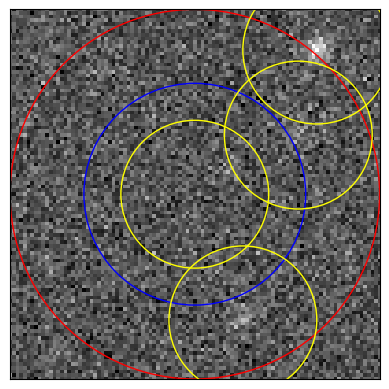

In [6]:
cal = prob[1]
ax = cal.plot(roi = ((prob[2], prob[3]), 100))
cal.add_point(ax,prob[2], prob[3], r=50)
cal.add_point(ax,Angle(sources["coord_ra"][id_near], radians).asDegrees(), Angle(sources["coord_dec"][id_near], radians).asDegrees(), r=30, c="blue")
for source in sources:
    cal.add_point(ax,Angle(source["coord_ra"], radians).asDegrees(), Angle(source["coord_dec"], radians).asDegrees(), r=20, c="yellow")

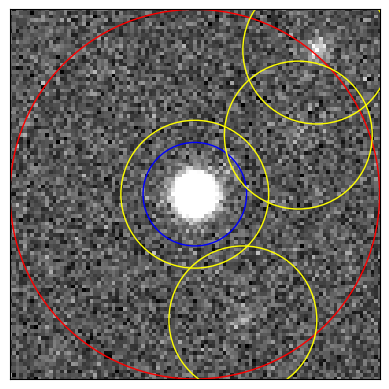

In [8]:
cal = Calexp(prob[-1])
ax = cal.plot(roi = ((prob[2], prob[3]), 100))
cal.add_point(ax,prob[2], prob[3], r=50)
cal.add_point(ax,Angle(sources["coord_ra"][id_near], radians).asDegrees(), Angle(sources["coord_dec"][id_near], radians).asDegrees(), r=28/2, c="blue")
for source in sources:
    cal.add_point(ax,Angle(source["coord_ra"], radians).asDegrees(), Angle(source["coord_dec"], radians).asDegrees(), r=20, c="yellow")

In [ ]:
if

In [23]:
columns_flux, columns_err

(['base_Blendedness_raw_child_instFlux',
  'base_Blendedness_raw_parent_instFlux',
  'base_Blendedness_abs_child_instFlux',
  'base_Blendedness_abs_parent_instFlux',
  'base_SdssShape_instFlux',
  'slot_Shape_instFlux',
  'base_SdssShape_instFlux_xx_Cov',
  'slot_Shape_instFlux_xx_Cov',
  'base_SdssShape_instFlux_yy_Cov',
  'slot_Shape_instFlux_yy_Cov',
  'base_SdssShape_instFlux_xy_Cov',
  'slot_Shape_instFlux_xy_Cov',
  'base_CircularApertureFlux_3_0_instFlux',
  'base_CircularApertureFlux_4_5_instFlux',
  'base_CircularApertureFlux_6_0_instFlux',
  'base_CircularApertureFlux_9_0_instFlux',
  'base_CircularApertureFlux_12_0_instFlux',
  'slot_ApFlux_instFlux',
  'slot_CalibFlux_instFlux',
  'base_CircularApertureFlux_17_0_instFlux',
  'base_CircularApertureFlux_25_0_instFlux',
  'base_CircularApertureFlux_35_0_instFlux',
  'base_CircularApertureFlux_50_0_instFlux',
  'base_CircularApertureFlux_70_0_instFlux',
  'base_CompensatedTophatFlux_12_instFlux',
  'base_CompensatedTophatFlux_1

In [ ]:
vv =[cal.get_mag(flux, flux_err) for flux, flux_err in zip(sources["base_PsfFlux_instFlux"], sources["base_PsfFlux_instFluxErr"])]

In [ ]:
# for i, (f, ferr) in enumerate(zip(flux, flux_err)):
    if f is not np.nan:
        mag, mag_err = calexp.get_mag(f, ferr)
        print("calexp: Measured ", mag, mag_err)
        mag, mag_err = inj_calexp.get_mag(f, ferr)
        print("inj_calexp: Measured ", mag, mag_err)
        print("Injected ", lc.data["mag_sim"][idx])